**Load data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle

In [3]:
df = pd.read_csv("../data/churn2.csv")

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,NaN
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,NaN
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,NaN
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,NaN
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,NaN


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

**Summary of raw data as imported**

We have over 10,000 rows, and 21 columns
Columns:
* CLIENTNUM probably just an id number, not likely to be informative.
* Attrition_Flag is the dependent variable we are trying to predict (churn/non-churn etc)
* Several columns like Gender, Marital status are really categorical, rather than object type. Should look at label encoding the unique values.
* There is an Unnamed column with 0 non-null values this can be safely dropped.
* Lots of informative looking numerical features/columns to do with transaction stats. Might be able to gain some information by engineering new features as combinations of these.

**Data cleaning**

Lowercase col names

In [6]:
df.columns = df.columns.str.lower()

"unnamed" empty column

In [7]:

df = df.drop(columns='unnamed: 21')

attrition_flag (churn)

In [8]:
df.loc[:,'churn'] = (df['attrition_flag'] == 'Attrited Customer').astype(int)
df = df.drop(columns='attrition_flag')
df.churn.value_counts()

churn
0    8500
1    1627
Name: count, dtype: int64

Convert to categorical type

Convert to categorical type for efficiency and because ML models can't directly work with objects/strings, so these columns need to become encoded eventually anyway.

In [9]:
df.loc[:,'gender'] = df.gender.astype('category')
df.loc[:,'education_level'] = df.education_level.astype('category')
df.loc[:,'marital_status'] = df.marital_status.astype('category')
df.loc[:,'income_category'] = df.income_category.astype('category')
df.loc[:,'card_category'] = df.card_category.astype('category')

Null values

In [10]:

df.isna().sum()

clientnum                   0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
churn                       0
dtype: int64

In this case, there are zero null/NaN values. All columns are populated for all 10,000 customer records so no imputation looks necessary.

However it looks like there might be some "unknown" data for income category

marital_status

In [11]:
df.marital_status.value_counts()

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64

There are 749 "unknowns" out of 10,000 records. This is significant enough that we shouldn't just drop these records, we should try to fill these.

Let's use the strategy to impute using the most common category.

In [12]:
def fill_marital_status(df):
  '''Replace Unknown with Married.'''
  df.loc[:,'marital_status'] = df.marital_status.replace('Unknown','Married')
  return df

df = fill_marital_status(df)
df.marital_status.value_counts()

marital_status
Married     5436
Single      3943
Divorced     748
Name: count, dtype: int64

Income_category

In [13]:
df.income_category.value_counts()


income_category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64

There are even more "unknown" salary (1112).

For now we will impute this simply using the "most_common" category (Less than $40k).

However income is likely to be quite linked to other features. With more time we could impute this by grouped information on some of these demographic features. For future, in case we would come back to change this imputation strategy, let's identify some features we would group by. Plot distributions vs income.

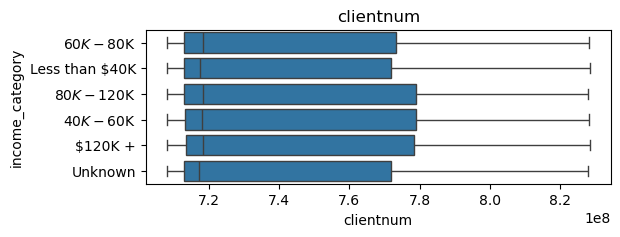

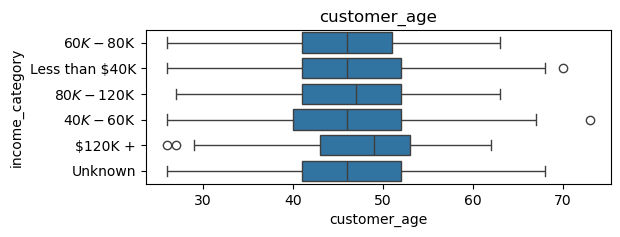

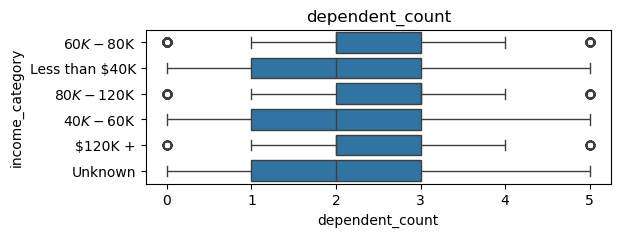

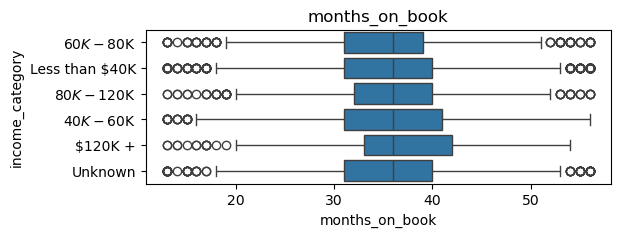

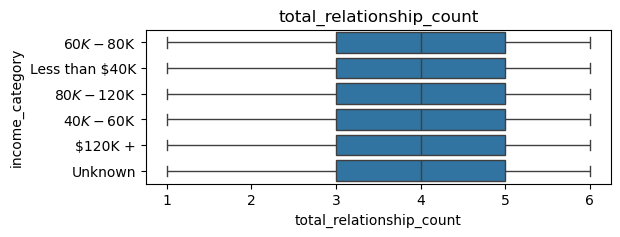

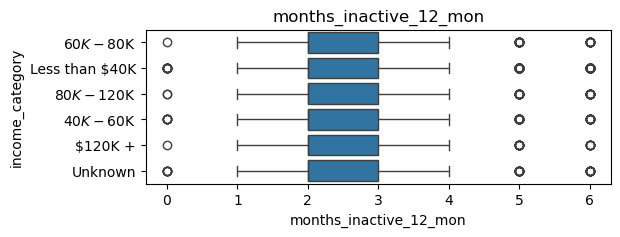

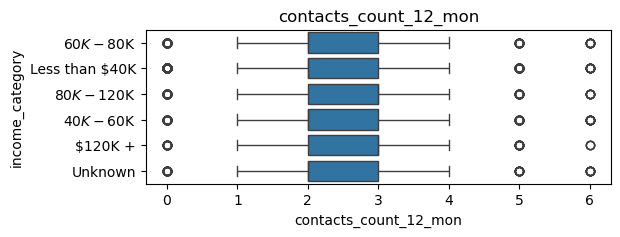

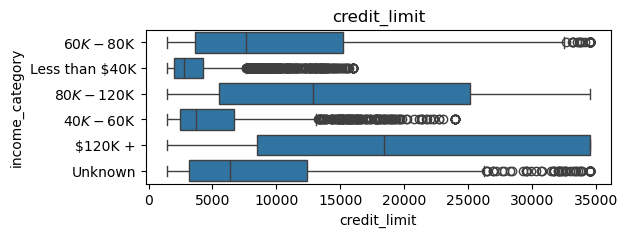

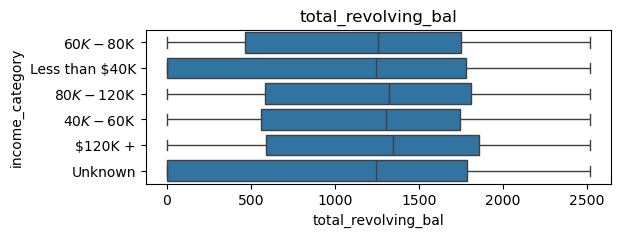

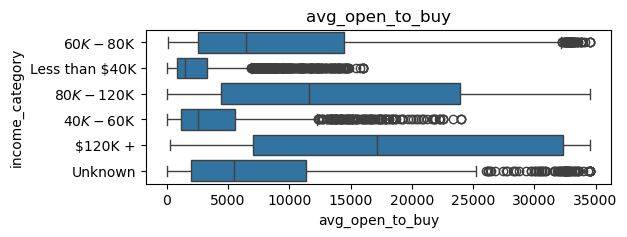

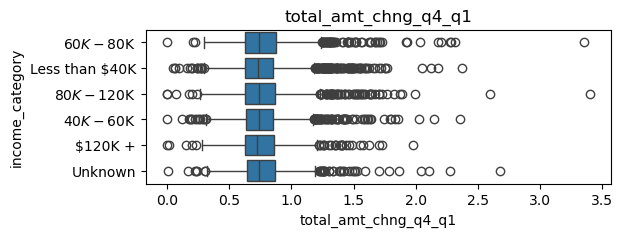

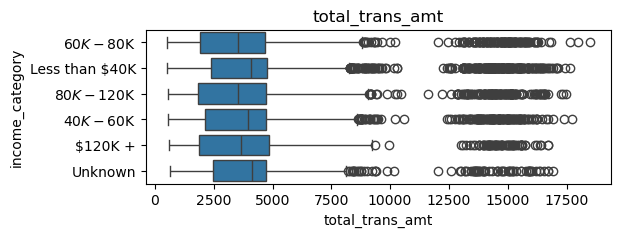

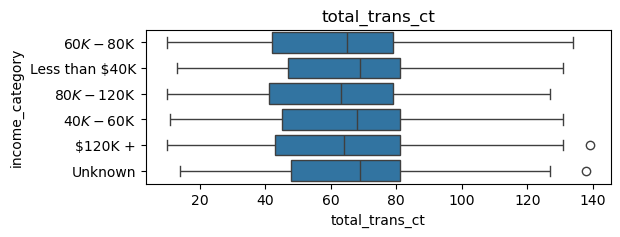

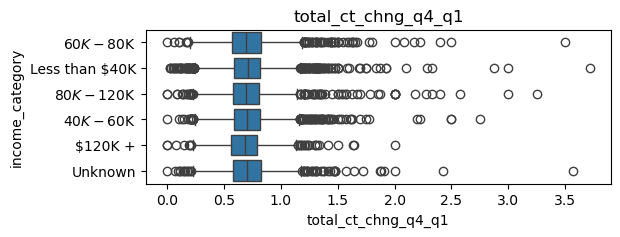

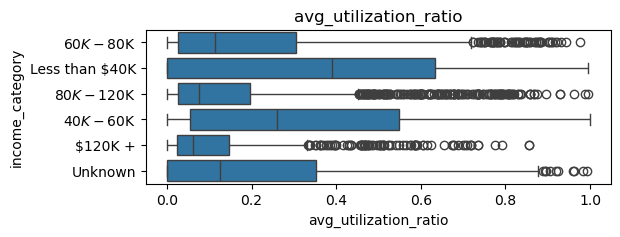

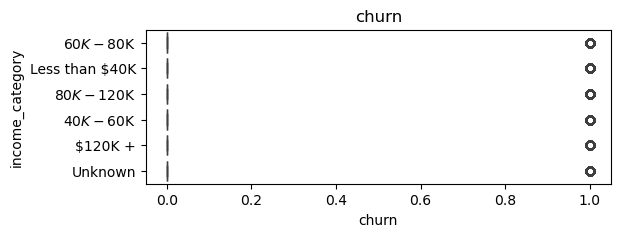

In [14]:
def plot_vs_income(df, col):
    '''Plot a side-by-side boxplot and histogram for both churn == 0 and 1'''
    fig = plt.figure()
    fig.set_size_inches(6,2)
    ax = fig.add_subplot()
    sns.boxplot(data=df, x=col, y='income_category', orient='h', ax=ax);
    ax.set_title(f'{col}')
    
for col in df.select_dtypes(np.number):
    plot_vs_income(df, col)

Good candidates for the grouping and imputation on income_category could be: age, credit_limit. However, more time and care would need to be taken to ensure this doesn't needlessly bias the model training later.

So for now just replace all Unknowns using the most_common value

In [15]:
def fill_incomes(df):
  '''Replace Unknown with "less than 40k".'''
  df.loc[:,'income_category'] = df.income_category.replace('Unknown','Less than $40K')
  return df

df = fill_incomes(df)
df.income_category.value_counts()

income_category
Less than $40K    4673
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
$120K +            727
Name: count, dtype: int64

**Exploratory analysis**

Basic statistics

In [16]:
df.describe().round(1)

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn
count,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0,10127.0
mean,739177606.3,46.3,2.3,35.9,3.8,2.3,2.5,8632.0,1162.8,7469.1,0.8,4404.1,64.9,0.7,0.3,0.2
std,36903783.5,8.0,1.3,8.0,1.6,1.0,1.1,9088.8,815.0,9090.7,0.2,3397.1,23.5,0.2,0.3,0.4
min,708082083.0,26.0,0.0,13.0,1.0,0.0,0.0,1438.3,0.0,3.0,0.0,510.0,10.0,0.0,0.0,0.0
25%,713036770.5,41.0,1.0,31.0,3.0,2.0,2.0,2555.0,359.0,1324.5,0.6,2155.5,45.0,0.6,0.0,0.0
50%,717926358.0,46.0,2.0,36.0,4.0,2.0,2.0,4549.0,1276.0,3474.0,0.7,3899.0,67.0,0.7,0.2,0.0
75%,773143533.0,52.0,3.0,40.0,5.0,3.0,3.0,11067.5,1784.0,9859.0,0.9,4741.0,81.0,0.8,0.5,0.0
max,828343083.0,73.0,5.0,56.0,6.0,6.0,6.0,34516.0,2517.0,34516.0,3.4,18484.0,139.0,3.7,1.0,1.0


Check more precisely what proportion of the data is for churned customers

In [17]:
df.churn.mean().round(3) * 100


np.float64(16.1)

So actually 16.1% of the data is for customers who have churned (inactive/have left the bank).

That's quite a large class imbalance, we will have to be mindful of this when training a prediction model.

Let's look at some general summary stats for categorical features

In [19]:
df.dtypes


clientnum                     int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
avg_open_to_buy             float64
total_amt_chng_q4_q1        float64
total_trans_amt               int64
total_trans_ct                int64
total_ct_chng_q4_q1         float64
avg_utilization_ratio       float64
churn                         int64
dtype: object

In [20]:
df.describe(include='object')


,gender,education_level,marital_status,income_category,card_category
count,10127,10127,10127,10127,10127
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,5358,3128,5436,4673,9436


So this bank's customer base mostly comprises of:

* Females (out of 2 categories, representing over 1/2 of customer-base)
* Graduate level education (out of 7 categories, 1/3rd of the customer-base)

        - Seems like a large bias towards grads.
* Married (out of 4 categories, just less than half of customer-base

        - Also seems strongly biased towards married people.
* Incomes of less than $40k (out of 6 categories)

        - Again strong bias towards incomes less than $40k.
* Blue card customers (out of 4 categories, almost 95% of customer base!)

        - Heavily biased towards blue card holders. Must be the standard option.

Scatter matrix

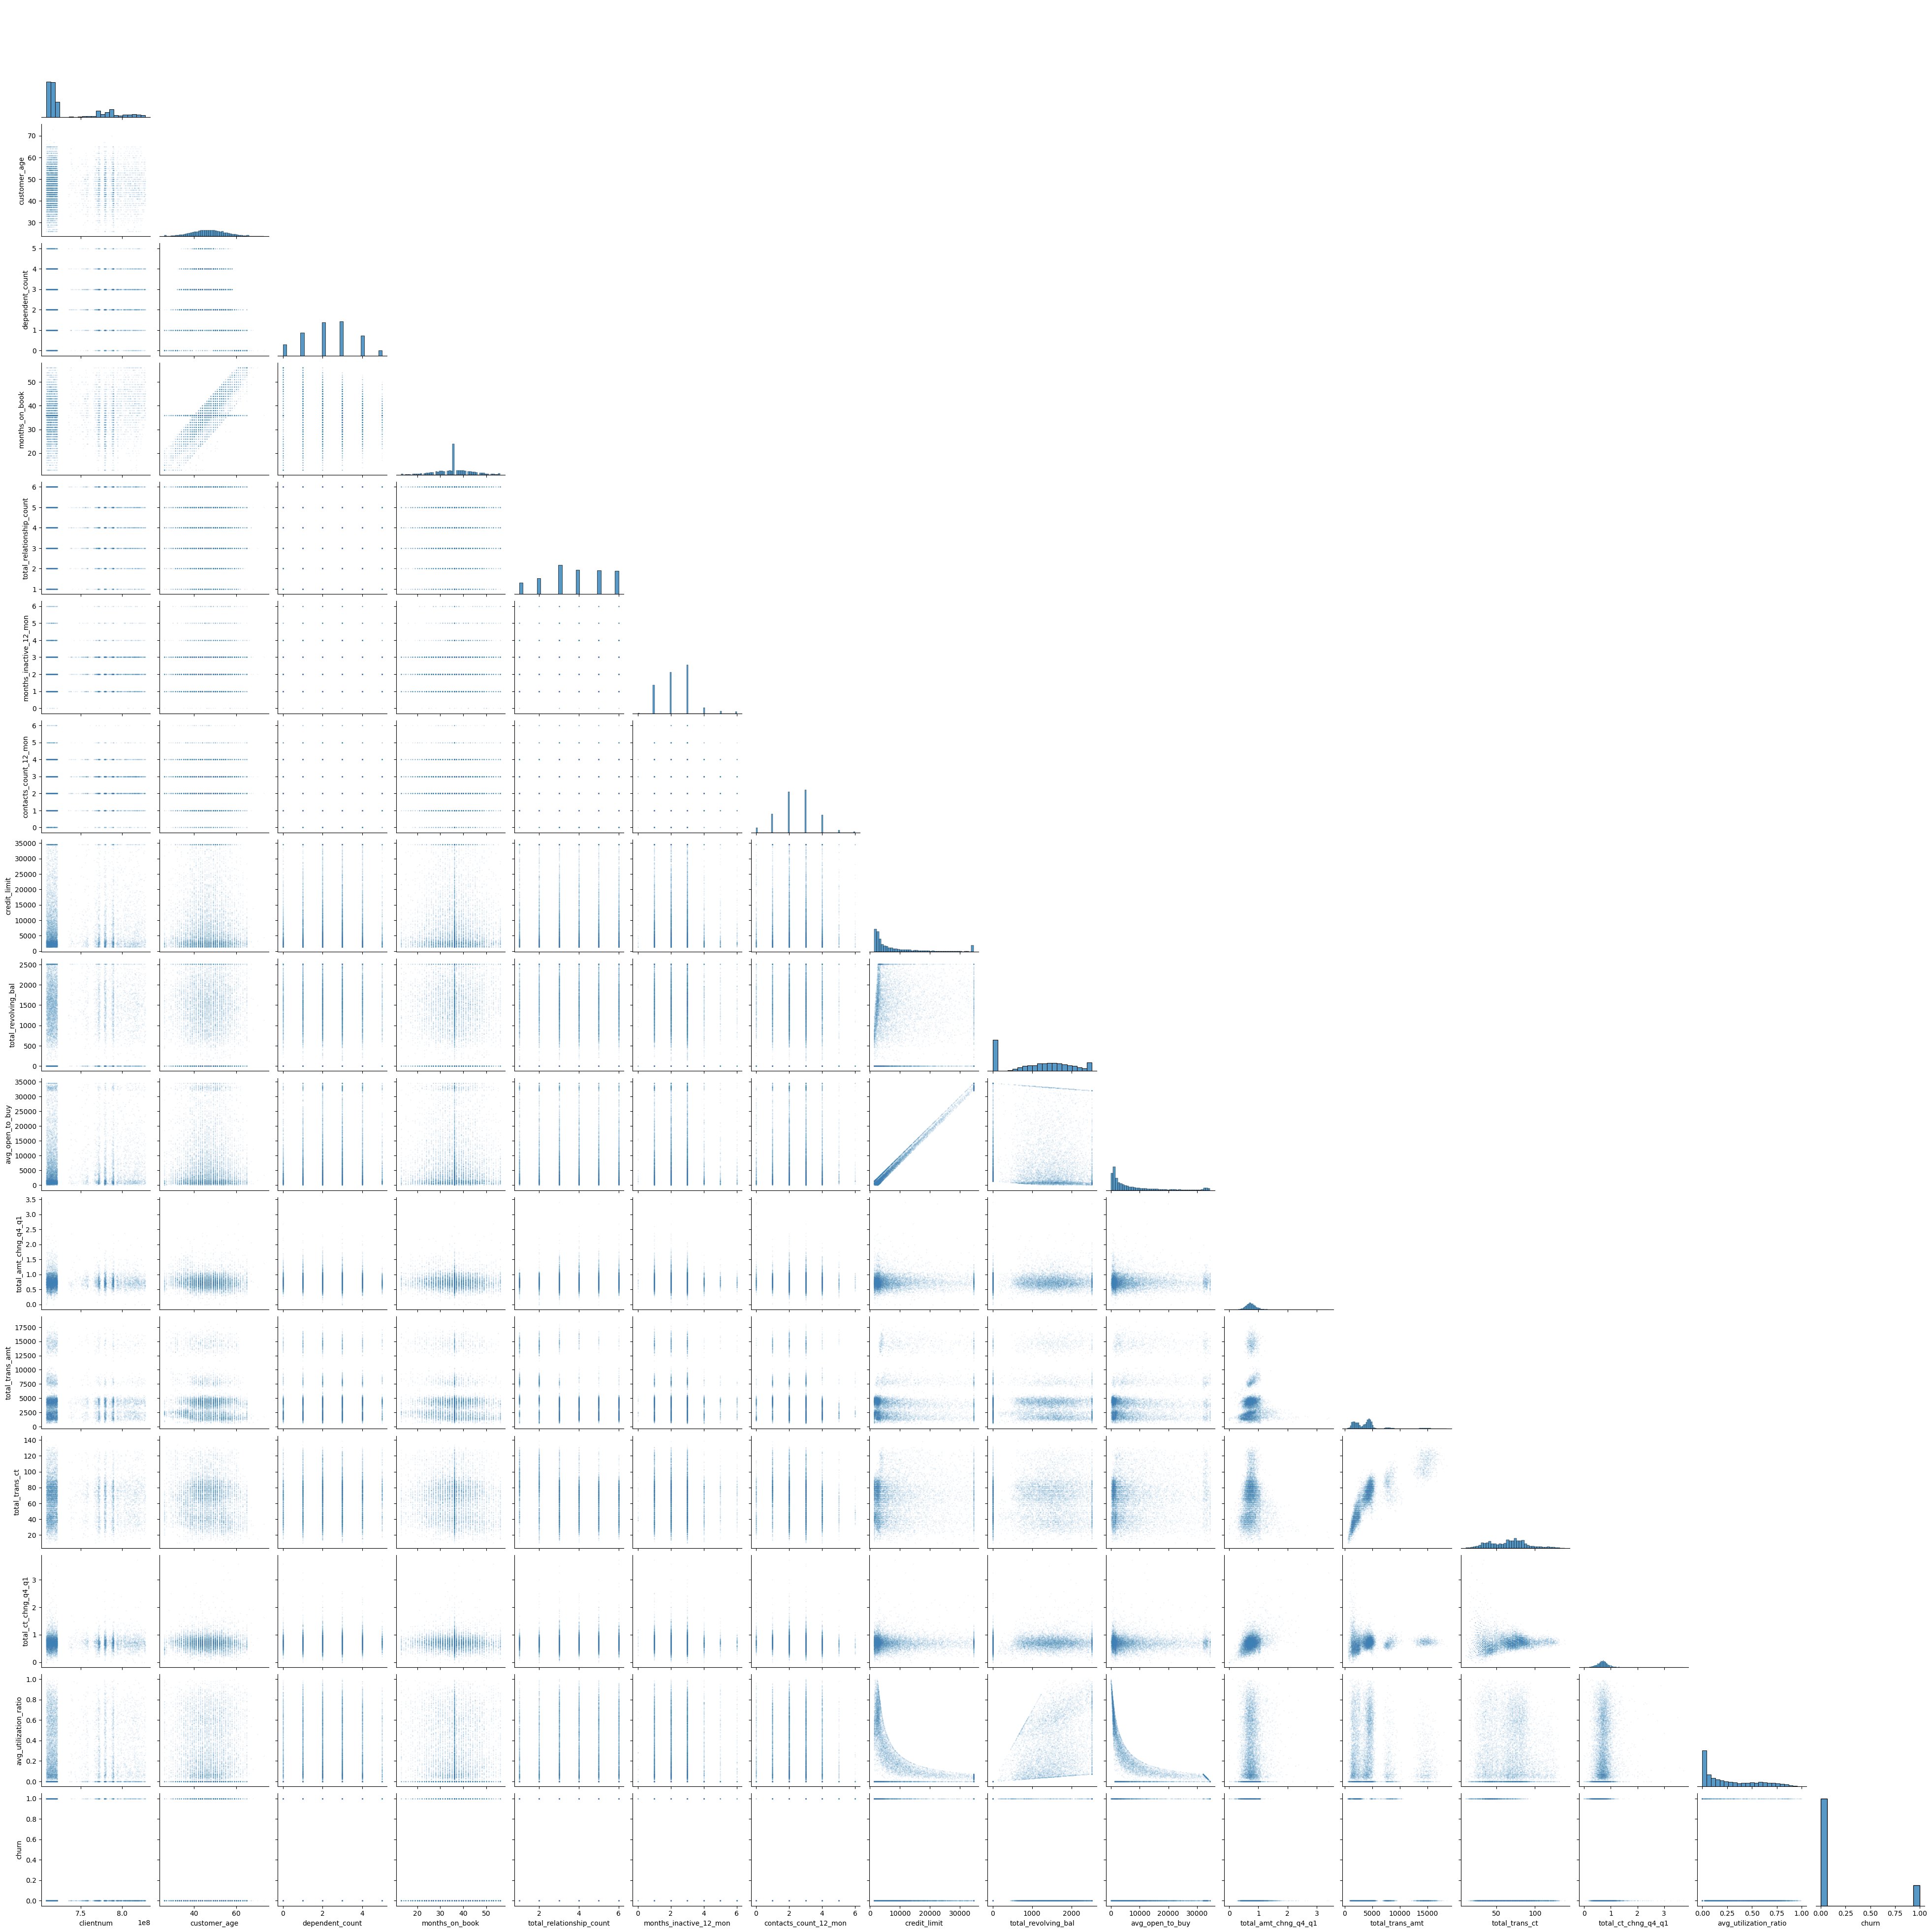

In [21]:
sns.pairplot(df, plot_kws={'alpha':0.1, 's':2}, corner=True);


Correlation matrix

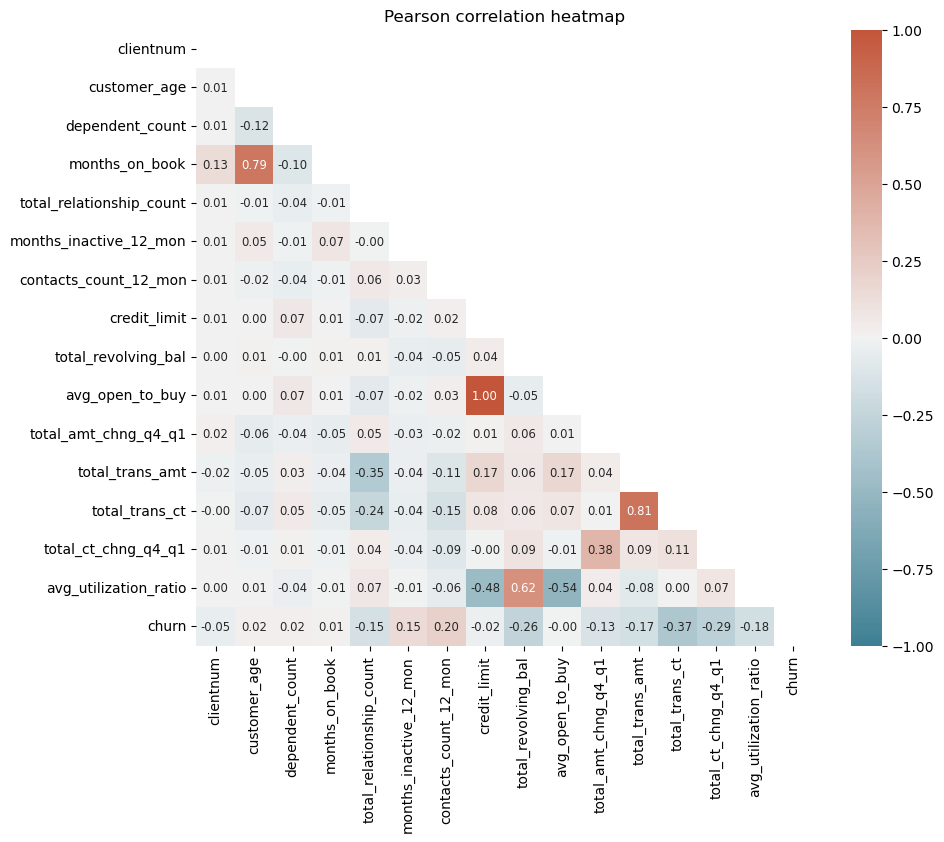

In [24]:
# Plot with mask for triangle plot only
def plot_corr_matrix(df):
    '''Plots formatted correlation matrix for the supplied df.'''
    fig = plt.figure()
    fig.set_size_inches(10,8)
    ax = fig.add_subplot()

    corr_mat = df.select_dtypes(include=np.number).corr()

    mask = np.triu(corr_mat)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr_mat, square=True, mask=mask, cmap=cmap, 
                annot=True, fmt='.2f', vmin=-1, vmax=1,
                annot_kws={'fontsize':'small'},
                ax=ax);
    ax.set_title('Pearson correlation heatmap');
    return corr_mat
    
corr_mat = plot_corr_matrix(df)

For clarity, print out a list of correlation coeffs vs the dependent variable "churn"

In [25]:
corr_mat['churn'].sort_values(ascending=False)

churn                       1.000000
contacts_count_12_mon       0.204491
months_inactive_12_mon      0.152449
dependent_count             0.018991
customer_age                0.018203
months_on_book              0.013687
avg_open_to_buy            -0.000285
credit_limit               -0.023873
clientnum                  -0.046430
total_amt_chng_q4_q1       -0.131063
total_relationship_count   -0.150005
total_trans_amt            -0.168598
avg_utilization_ratio      -0.178410
total_revolving_bal        -0.263053
total_ct_chng_q4_q1        -0.290054
total_trans_ct             -0.371403
Name: churn, dtype: float64

Top few correlations vs churn (sorted by coefficient):

* total_trans_ct (-ve correlation)
* total_ct_chng_q4_q1 (-ve correlation)
* total_revolving_bal (-ve correlation)
* contacts_count_12_mon (+ve correlation)
* avg_utilization_ratio (-ve correlation)
* months_inactive_12_mon (+ve correlation)

Summary

* Negative correlations with features that represent "usage of credit".
* Positive correlations with features that represent "lack of usage of credit".

Numerical features, a closer look

In [26]:
df_num = df.select_dtypes(include=['int','float'])
df_num.columns.tolist()

['clientnum',
 'customer_age',
 'dependent_count',
 'months_on_book',
 'total_relationship_count',
 'months_inactive_12_mon',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'avg_open_to_buy',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'churn']

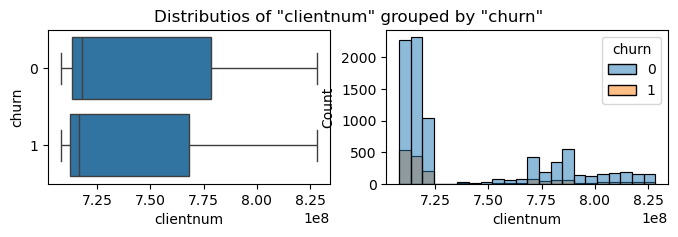

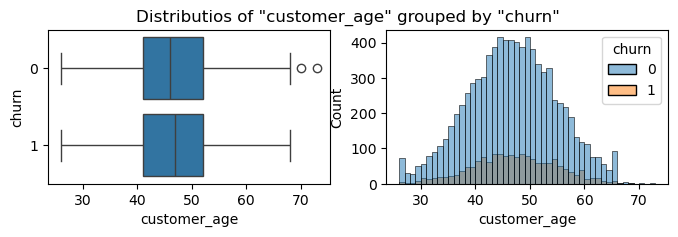

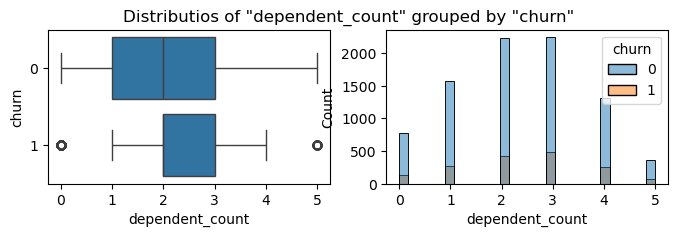

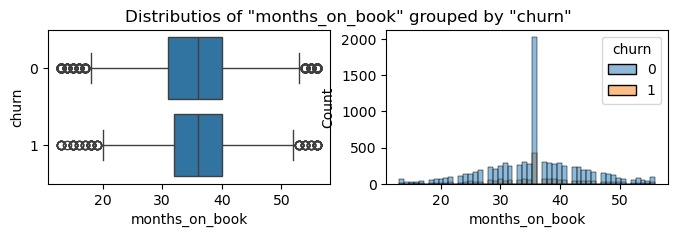

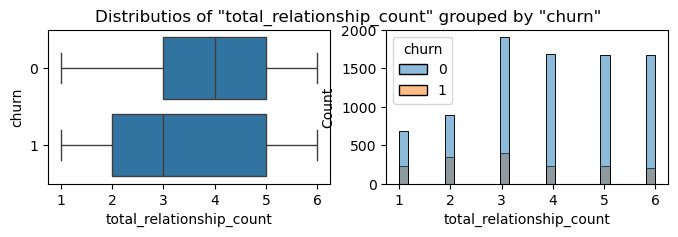

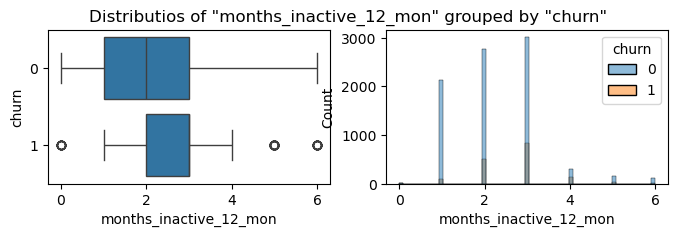

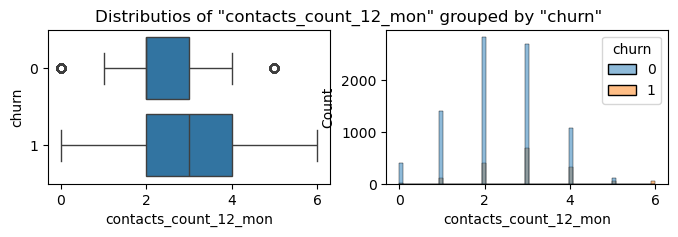

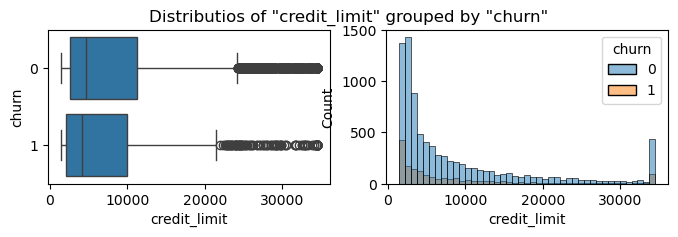

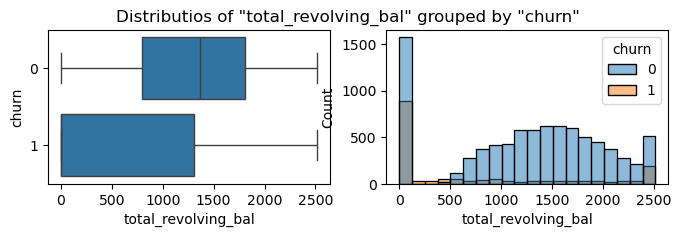

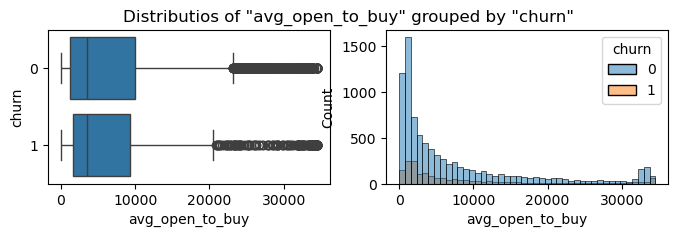

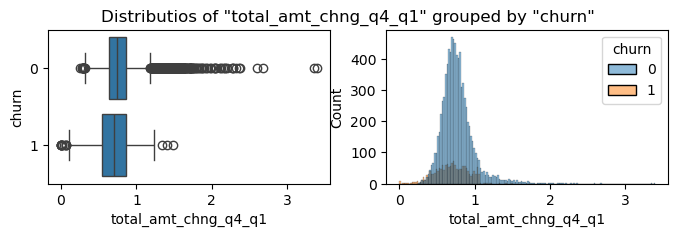

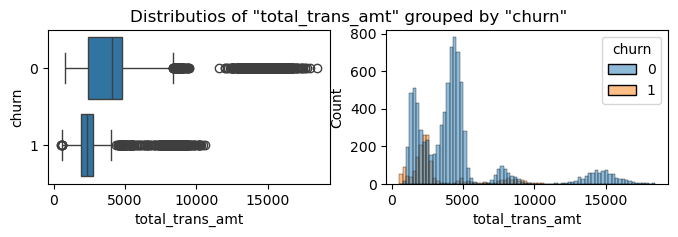

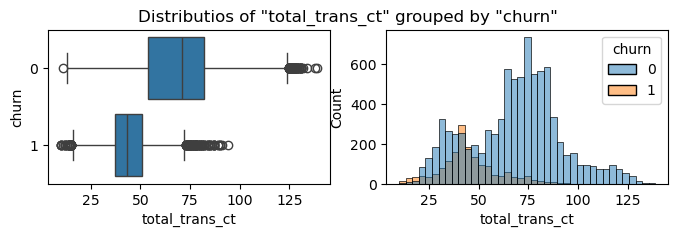

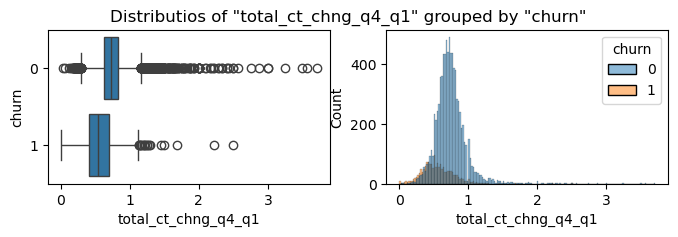

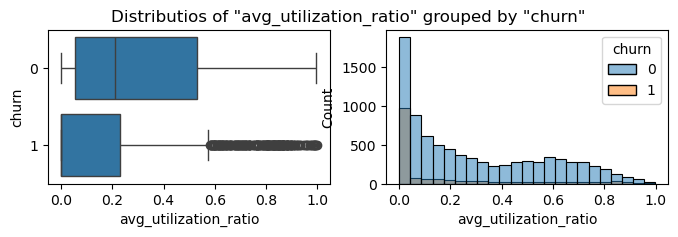

In [27]:
def plot_vs_churn(df, col):
    '''Plot a side-by-side boxplot and histogram for both churn == 0 and 1'''
    fig = plt.figure()
    fig.set_size_inches(8,2)
    ax = fig.add_subplot(1,2,1)
    sns.boxplot(data=df, x=col, y='churn', orient='h');

    ax = fig.add_subplot(1,2,2)
    sns.histplot(data=df, x=col, hue='churn');
    fig.suptitle(f'Distributios of "{col}" grouped by "churn"')
    
for col in df_num.columns:
    if col == 'churn': continue
    plot_vs_churn(df, col)

Categorical features

In [31]:
df.select_dtypes(include='object')


,gender,education_level,marital_status,income_category,card_category
0,M,High School,Married,$60K - $80K,Blue
1,F,Graduate,Single,Less than $40K,Blue
2,M,Graduate,Married,$80K - $120K,Blue
3,F,High School,Married,Less than $40K,Blue
4,M,Uneducated,Married,$60K - $80K,Blue
...,...,...,...,...,...
10122,M,Graduate,Single,$40K - $60K,Blue
10123,M,Unknown,Divorced,$40K - $60K,Blue
10124,F,High School,Married,Less than $40K,Blue
10125,M,Graduate,Married,$40K - $60K,Blue


In [32]:
df[df.churn == 1].describe(include='object')


,gender,education_level,marital_status,income_category,card_category
count,1627,1627,1627,1627,1627
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,930,487,838,799,1519


In [33]:
df[df.churn == 0].describe(include='object')


,gender,education_level,marital_status,income_category,card_category
count,8500,8500,8500,8500,8500
unique,2,7,3,5,4
top,F,Graduate,Married,Less than $40K,Blue
freq,4428,2641,4598,3874,7917


In [34]:
def categorywise_churn_rate(df, col, verbose=False):
    '''Print the churn rate for each category in a given categorical column.  Also returns a dict'''
    groups = df.groupby(col)
    churn_rates = dict()
    for name, group in groups:
        churn_rate = group.churn.mean().round(3)*100
        if verbose: print(f'In feature:{col:<20} category:{name:<15} has a churn_rate:{churn_rate:.1f}%')
        churn_rates[name] = churn_rate
        
    return churn_rates

for col in ['gender','education_level','marital_status','income_category','card_category']:
    churn_rates_gender = categorywise_churn_rate(df, col, verbose=True)
    print('-'*60)

In feature:gender               category:F               has a churn_rate:17.4%
In feature:gender               category:M               has a churn_rate:14.6%
------------------------------------------------------------
In feature:education_level      category:College         has a churn_rate:15.2%
In feature:education_level      category:Doctorate       has a churn_rate:21.1%
In feature:education_level      category:Graduate        has a churn_rate:15.6%
In feature:education_level      category:High School     has a churn_rate:15.2%
In feature:education_level      category:Post-Graduate   has a churn_rate:17.8%
In feature:education_level      category:Uneducated      has a churn_rate:15.9%
In feature:education_level      category:Unknown         has a churn_rate:16.9%
------------------------------------------------------------
In feature:marital_status       category:Divorced        has a churn_rate:16.2%
In feature:marital_status       category:Married         has a churn_rate:15.4

**Feature engineering**

**Adding linear combinations of numerical features**

Tenure / age

In [36]:
df.loc[:,'tenure_per_age'] = df.months_on_book / (df.customer_age * 12)


Utilisation / age

In [37]:
df.loc[:,'utilisation_per_age'] = df.avg_utilization_ratio / df.customer_age


credit limit / age

In [38]:
df.loc[:,'credit_lim_per_age'] = df.credit_limit / df.customer_age


total transactions / credit limit

In [39]:

df.loc[:,'total_trans_amt_per_credit_lim'] = df.total_trans_amt / df.credit_limit
df.loc[:,'total_trans_ct_per_credit_lim'] = df.total_trans_ct / df.credit_limit

Polynomial features - sklearn

This is just experimental, these features are not used in modelling yet as they probably introduce massive redundancy and multicolinearity into the model, but might we a way of sqeezing a bit more performance out.

In [40]:
from sklearn.preprocessing import PolynomialFeatures

cols = ['customer_age','dependent_count','months_on_book',
        'total_relationship_count','months_inactive_12_mon',
        'contacts_count_12_mon','credit_limit','total_revolving_bal',
        'avg_open_to_buy','total_amt_chng_q4_q1','total_trans_amt','total_trans_ct',
        'total_ct_chng_q4_q1','avg_utilization_ratio']

poly = PolynomialFeatures(2, include_bias=False)
poly_feats = poly.fit_transform(df[cols])
df_poly = pd.DataFrame(poly_feats, columns=poly.get_feature_names_out())
df_poly.loc[:,'churn'] = df.churn

In [41]:

# Print the top 10 values by (absolute) correlation coef
df_poly.corr()['churn'].abs().sort_values(ascending=False)[1:11]

total_trans_ct total_ct_chng_q4_q1         0.410125
total_trans_ct                             0.371403
total_amt_chng_q4_q1 total_trans_ct        0.351964
total_trans_ct^2                           0.344728
customer_age total_trans_ct                0.334682
total_relationship_count total_trans_ct    0.328217
total_revolving_bal total_trans_ct         0.319486
months_on_book total_trans_ct              0.313826
total_revolving_bal total_ct_chng_q4_q1    0.299294
total_ct_chng_q4_q1                        0.290054
Name: churn, dtype: float64

Final cleaning - Dropping clientnum

In [42]:
df = df.drop(columns='clientnum')


Final EDA - check correlations of engineered features

In [43]:
# Use function written earlier
cols = ['churn', 'tenure_per_age', 'utilisation_per_age', 'credit_lim_per_age',
       'total_trans_amt_per_credit_lim','total_trans_ct_per_credit_lim']
df[cols].corr()['churn'].sort_values(ascending=False)

churn                             1.000000
tenure_per_age                    0.000465
credit_lim_per_age               -0.029887
total_trans_ct_per_credit_lim    -0.132511
total_trans_amt_per_credit_lim   -0.133222
utilisation_per_age              -0.171645
Name: churn, dtype: float64

Final preprocessing function

In [45]:

def preprocess_raw(df):
    df.columns = df.columns.str.lower()
    
    df = df.drop(columns='unnamed: 21') if 'unnamed: 21' in df.columns else df
    
    df.loc[:,'churn'] = (df['attrition_flag'] == 'Attrited Customer').astype(int)
    df = df.drop(columns='attrition_flag') if 'attrition_flag' in df.columns else df
    
    df.loc[:,'gender'] = df.gender.astype('category')
    df.loc[:,'education_level'] = df.education_level.astype('category')
    df.loc[:,'marital_status'] = df.marital_status.astype('category')
    df.loc[:,'income_category'] = df.income_category.astype('category')
    df.loc[:,'card_category'] = df.card_category.astype('category')
    
    df = fill_marital_status(df)
    
    df = fill_incomes(df)

    df.loc[:,'tenure_per_age'] = df.months_on_book / (df.customer_age * 12)
    df.loc[:,'utilisation_per_age'] = df.avg_utilization_ratio / df.customer_age
    df.loc[:,'credit_lim_per_age'] = df.credit_limit / df.customer_age
    df.loc[:,'total_trans_amt_per_credit_lim'] = df.total_trans_amt / df.credit_limit
    df.loc[:,'total_trans_ct_per_credit_lim'] = df.total_trans_ct / df.credit_limit
    
    df = df.drop(columns='clientnum')
    
    return df

# Check the preprocessing is workingwith a temporary df
df = preprocess_raw(pd.read_csv("../data/churn2.csv"))

In [46]:
df.head()

,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,...,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn,tenure_per_age,utilisation_per_age,credit_lim_per_age,total_trans_amt_per_credit_lim,total_trans_ct_per_credit_lim
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,...,1144,42,1.625,0.061,0,0.072222,0.001356,282.022222,0.090143,0.003309
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,...,1291,33,3.714,0.105,0,0.074830,0.002143,168.489796,0.156371,0.003997
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,...,1887,20,2.333,0.000,0,0.058824,0.000000,67.019608,0.552077,0.005851
3,40,F,4,High School,Married,Less than $40K,Blue,34,3,4,...,1171,20,2.333,0.760,0,0.070833,0.019000,82.825000,0.353456,0.006037
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,...,816,28,2.500,0.000,0,0.043750,0.000000,117.900000,0.173028,0.005937


In [47]:
df.to_csv("datapreprocessed.csv", index=False)


In [64]:
X = df.drop(columns='churn')
y = df['churn']


In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


In [68]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [69]:
feature_names = preprocessor.get_feature_names_out()


In [70]:
print(X_train_processed.shape)
print(X_test_processed.shape)
print(len(feature_names))


(8101, 35)
(2026, 35)
35


In [72]:
# ==============================
# SAVE & VALIDATE PREPROCESSING
# (NO SMOTE)
# ==============================

import os
import pickle

# Create directory
os.makedirs("processors", exist_ok=True)

# 1) Save preprocessor
with open("processors/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)
print("✓ preprocessor saved")

# 2) Save feature names
with open("processors/feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)
print("✓ feature_names saved")

# 3) Save preprocessing strategy (no SMOTE)
with open("processors/preprocessing_strategy.pkl", "wb") as f:
    pickle.dump(
        {"imbalance_handling": "class_weight_balanced"},
        f
    )
print("✓ preprocessing strategy saved")

# 4) Save preprocessed datasets
datasets = {
    "X_train": X_train_processed,
    "X_test": X_test_processed,
    "y_train": y_train,
    "y_test": y_test
}

with open("processors/preprocessed_data.pkl", "wb") as f:
    pickle.dump(datasets, f)
print("✓ preprocessed_data saved")

print("\n✅ All preprocessing artefacts saved")

# ==============================
# LOAD & CHECK (sanity check)
# ==============================

with open("processors/preprocessor.pkl", "rb") as f:
    preprocessor_loaded = pickle.load(f)

with open("processors/feature_names.pkl", "rb") as f:
    feature_names_loaded = pickle.load(f)

with open("processors/preprocessed_data.pkl", "rb") as f:
    datasets_loaded = pickle.load(f)

print("\n🔍 Sanity check")
print("Nb features:", len(feature_names_loaded))
print(
    "Shapes:",
    datasets_loaded["X_train"].shape,
    datasets_loaded["X_test"].shape
)


✓ preprocessor saved
✓ feature_names saved
✓ preprocessing strategy saved
✓ preprocessed_data saved

✅ All preprocessing artefacts saved

🔍 Sanity check
Nb features: 35
Shapes: (8101, 35) (2026, 35)


In [74]:
import pickle

with open("processors/preprocessor.pkl", "rb") as f:
    preprocessor_loaded = pickle.load(f)

with open("processors/feature_names.pkl", "rb") as f:
    feature_names_loaded = pickle.load(f)

with open("processors/preprocessed_data.pkl", "rb") as f:
    datasets_loaded = pickle.load(f)

print(" Chargement OK")
print("Nb features:", len(feature_names_loaded))
print("Shapes:", datasets_loaded["X_train"].shape, datasets_loaded["X_test"].shape)


 Chargement OK
Nb features: 35
Shapes: (8101, 35) (2026, 35)


In [73]:
print("="*80)
print(" PREPROCESSING CHURN TERMINÉ!")
print("="*80)
print("Prochaine étape: entraînement de modèles (LogReg, RF, XGBoost, etc.)")

 PREPROCESSING CHURN TERMINÉ!
Prochaine étape: entraînement de modèles (LogReg, RF, XGBoost, etc.)
